# Colour Palette Generator

Functions:
1. *Process Image*
2. *Return string of 5 colours*
3. *Display Colours*

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from skimage import color
from collections import Counter
import cv2
import os

# Process Image

In [248]:
def prep_image(image_name):
  image = cv2.imread(image_name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # plt.imshow(image)
  # print("Shape Before: ", image.shape)
  image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
  image = image.reshape(image.shape[0]*image.shape[1], 3)
  # print("Shape After: ",image.shape)

  return image

## Extract Colours

In [249]:
def RGB2HEX(color):
  return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [250]:
def extract_colors(prepped_image, clusters, model, batch=300, type='hex'):

  if model=='mini':
    # print("Using Mini Batch K Means")
    kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=0, batch_size= batch)
  else:
    # print("Using K Means")
    kmeans = KMeans(n_clusters = clusters, random_state=0)

  extr_colors = kmeans.fit_predict(prepped_image)

  counts = Counter(extr_colors)
  centroid_colors = kmeans.cluster_centers_
  ordered_colors = [centroid_colors[i] for i in counts.keys()]
  rgb_colors = [ordered_colors[i] for i in counts.keys()]
  hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]

  if type=='rgb':
    return rgb_colors
  else:
    return hex_colors



## Display Colours


In [251]:
def extract_palette(image_name, color_type='hex'):
  processed_image = prep_image(image_name)
  if color_type == 'rgb':
    colors = extract_colors(processed_image, 5, 'mini', batch=200, type='rgb')
  else:
    colors = extract_colors(processed_image, 5, 'mini', batch=200)
  return colors


In [252]:
def directory_palettes(directory_name, colour_type):
  sample_palettes = []
  directory = directory_name
  i=0 
  
  for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        path = directory + "/" + filename
        
        if os.path.isfile(f) and len(sample_palettes)==i:
          palette = extract_palette(path, color_type=colour_type)
          sample_palettes.append(palette)
          
        i+=1
        
  return sample_palettes


In [253]:
def show_colours(list_colours):
  fig = plt.figure(figsize = (5, 1))
  length = len(list_colours)
  plt.bar(list_colours, [1]*length, color =list_colours, width = 1)
  plt.axis('off')
  plt.show()

In [254]:
def show_palette(image_name):
  processed_image = prep_image(image_name)
  hex_colors = extract_colors(processed_image, 5, 'mini', batch=200)
  show_colours(hex_colors)


In [255]:
def display_palettes(palettes):
  i=1
  for palette in palettes:
    print(i,")")
    i+=1
    show_colours(palette)

# Data

In [256]:
# fendi = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 2 Fall 2021 Couture/Fendi', 'hex')
# azzaro = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 2 Fall 2021 Couture/Azzaro', 'hex')
# pyer_moss = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 2 Fall 2021 Couture/Pyer Moss', 'hex')
# all = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 2 Fall 2021 Couture/All Images', 'hex')

# Colour Palette Preprocessing

In [257]:
def rgb_from_hex(color_hex):
  # hex colours are R(0,1) G(2,3) B(4,5) in base 16
  return tuple(int(color_hex[i:i+2], 16) for i in (0,2,4))

In [258]:
def get_palette_from_string(palette_list):
  list = [rgb_from_hex(color[1:]) for color in palette_list]
  # Sort Colours by brightness (R+G+B roughly) (or else, Yellow Brown and Brown yellow are interpreted as different colours)
  return sort_tuple(list)

In [259]:
def sort_tuple(list_of_tuples):
    list_of_tuples.sort(key = lambda x: x[1]+x[0]+x[2]) 
    return list_of_tuples

In [260]:
def convert_palettes_to_lab(rgb_palettes):
  scaled_palettes = np.array([rgb_palettes]) / 255.0
  lab_palettes = color.rgb2lab(scaled_palettes)
  return lab_palettes.flatten()

In [261]:
def features_from_list_of_palettes(list_of_palettes):
  list_of_lists = []
  for palette_list in list_of_palettes:
    lab_palette = convert_palettes_to_lab(get_palette_from_string(palette_list))
    list_of_lists.append(lab_palette)

  
  X = np.array(list_of_lists)
  return X

In [262]:
#TO SAVE PALETTES AS PNGs

def save_palette(palette, file_name):
  fig = plt.figure(figsize = (5, 1))
  length = len(palette)
  
  plt.bar(palette, [1]*length, color =palette, width = 1)
  plt.axis('off')

  plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0)
  plt.show()


In [263]:
def getImage(path, zoom):
    return OffsetImage(plt.imread(path), zoom=zoom)

# Visualisation


In [264]:
def scatter(X):
  # plt.scatter(X[:,0], X[:,1], c=colors)
  fig, ax = plt.subplots(figsize = (32, 18))
  
  # fig, ax = plt.subplots()
  x = X[:,0]
  y = X[:,1]
  ax.scatter(x, y)
  for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage(path, 0.08), (x0, y0), frameon=False)
    ax.add_artist(ab)
  plt.show()

In [309]:
# list_of_palettes = fendi + azzaro + pyer_moss
# list_of_palettes = all
# list_of_palettes_2 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 2 Fall 2021 Couture/alola', 'hex')
# list_of_palettes_3 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 3 Thumbails/Youtube', 'hex')

# list_of_palettes_4 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 4 Pokemon/sinnoh', 'hex')

# list_of_palettes_5 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 4 Pokemon/sinnoh', 'hex')


list_of_palettes_7 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 4 Pokemon/van gogh', 'hex')


list_of_palettes_8 = directory_palettes('/content/drive/MyDrive/ML Projects/Colour Extraction/Dataset 3 Thumbails/Netflix', 'hex')

In [310]:
print(len(list_of_palettes_8))

175


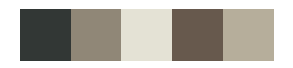

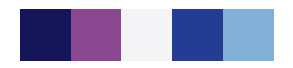

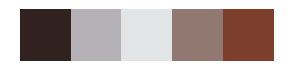

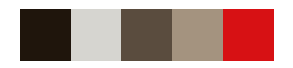

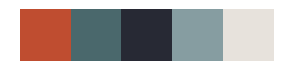

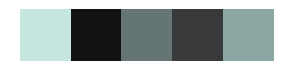

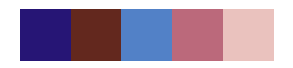

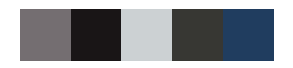

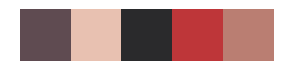

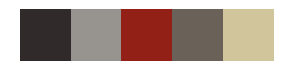

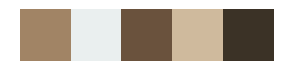

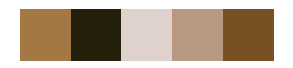

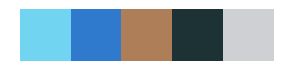

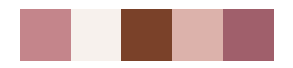

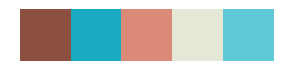

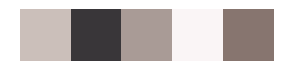

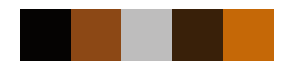

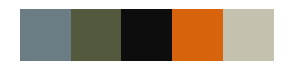

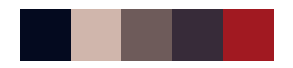

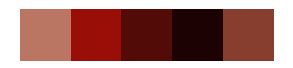

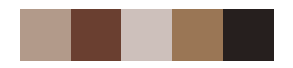

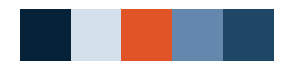

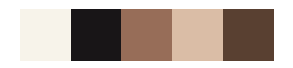

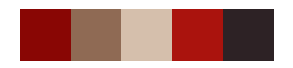

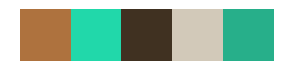

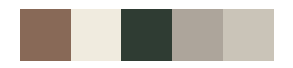

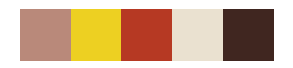

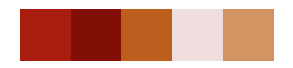

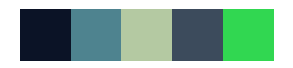

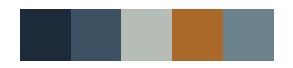

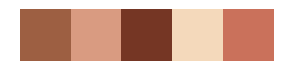

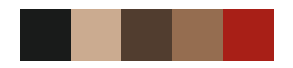

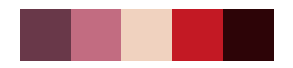

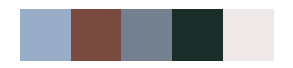

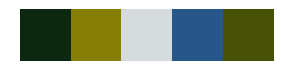

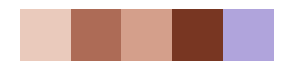

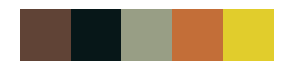

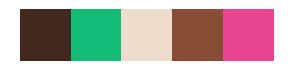

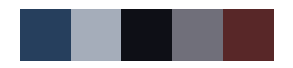

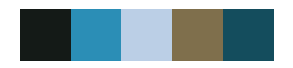

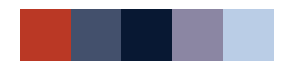

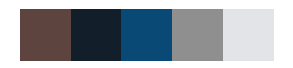

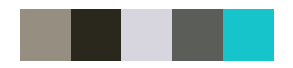

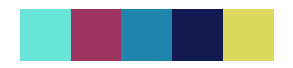

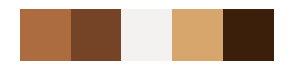

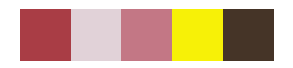

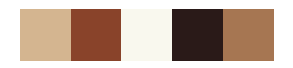

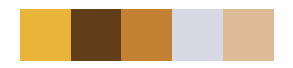

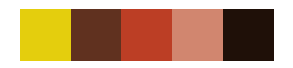

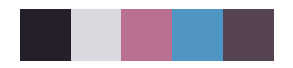

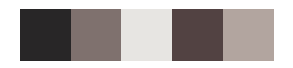

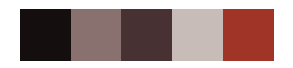

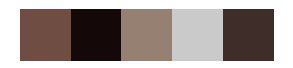

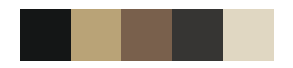

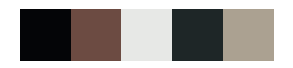

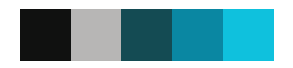

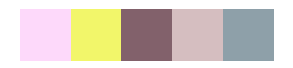

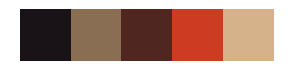

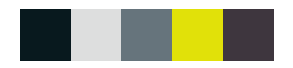

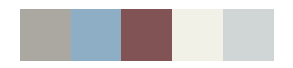

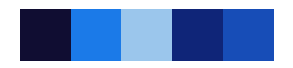

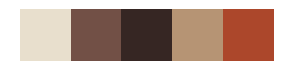

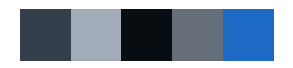

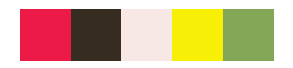

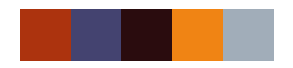

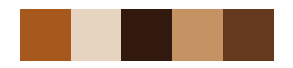

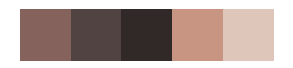

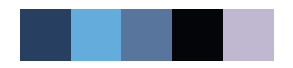

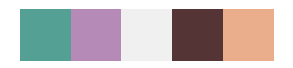

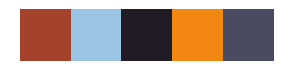

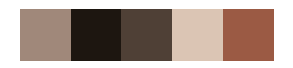

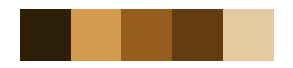

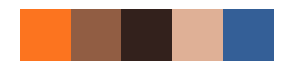

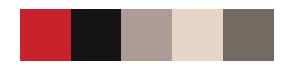

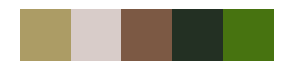

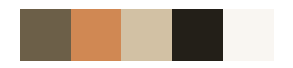

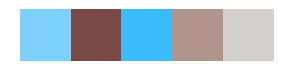

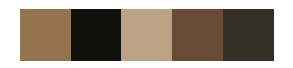

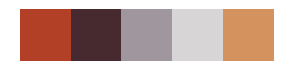

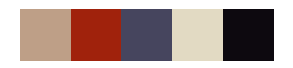

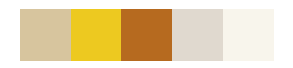

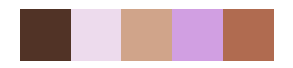

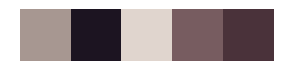

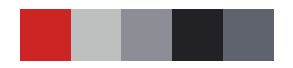

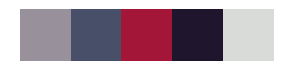

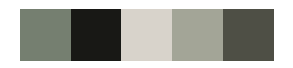

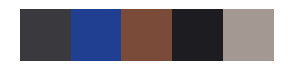

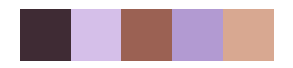

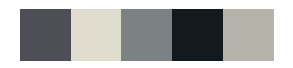

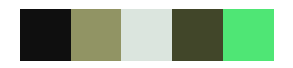

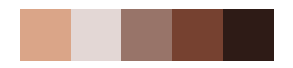

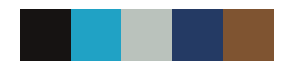

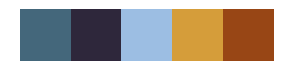

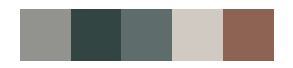

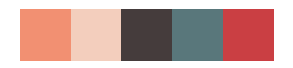

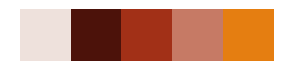

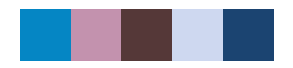

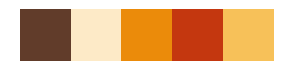

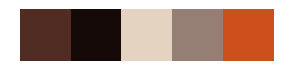

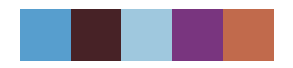

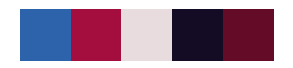

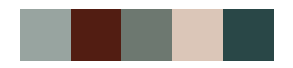

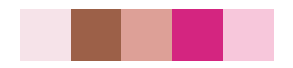

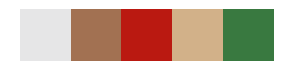

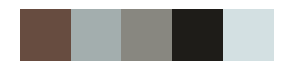

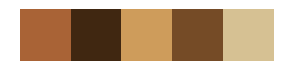

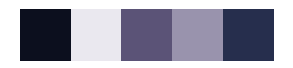

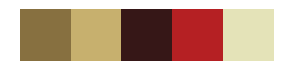

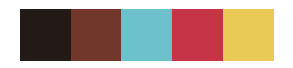

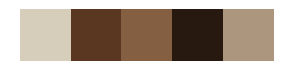

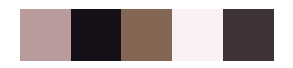

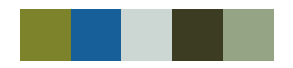

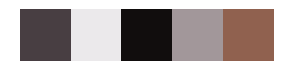

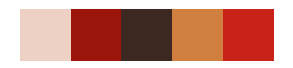

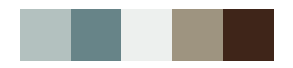

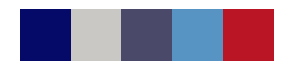

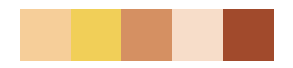

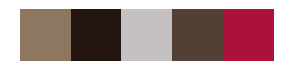

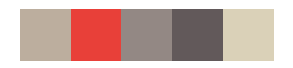

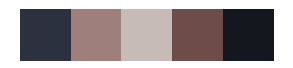

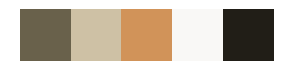

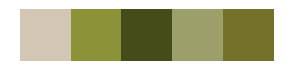

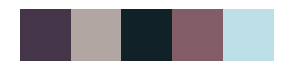

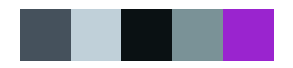

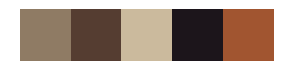

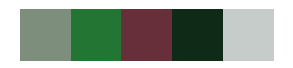

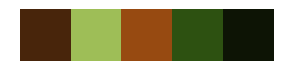

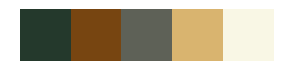

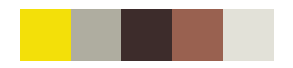

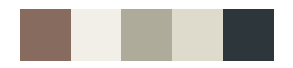

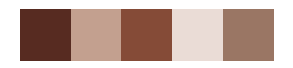

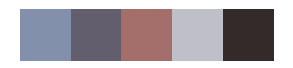

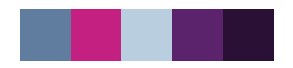

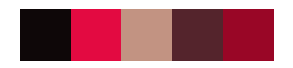

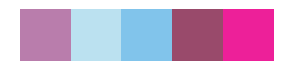

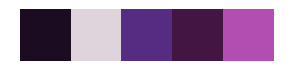

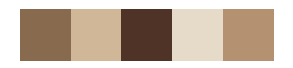

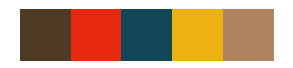

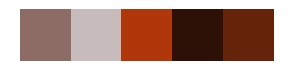

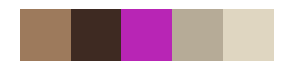

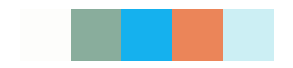

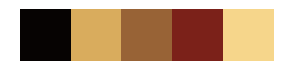

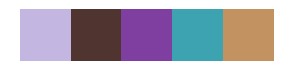

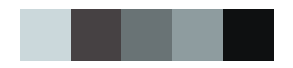

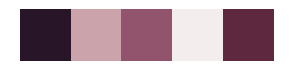

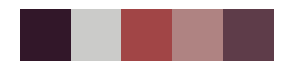

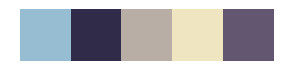

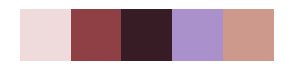

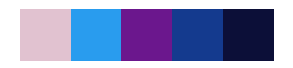

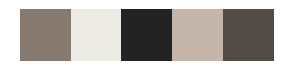

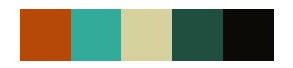

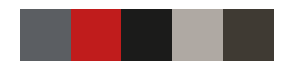

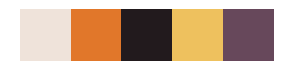

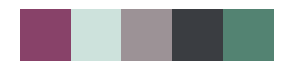

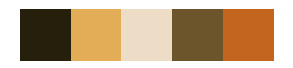

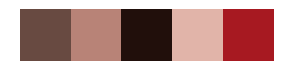

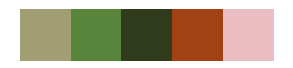

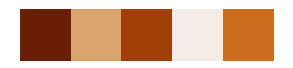

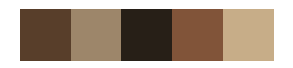

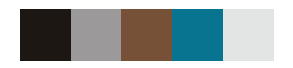

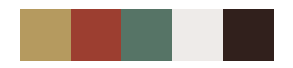

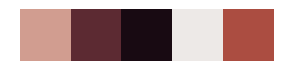

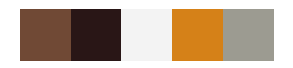

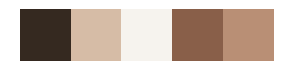

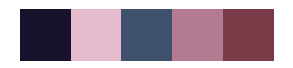

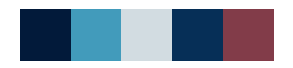

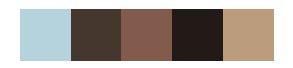

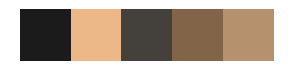

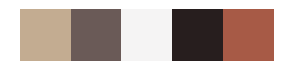

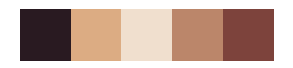

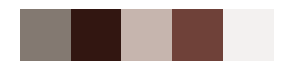

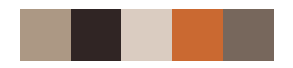

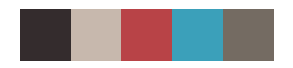

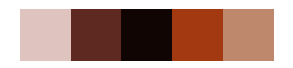

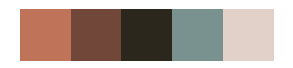

In [323]:
# Save images at paths
i=0
paths = [str(i)+".png" for i in range(len(list_of_palettes_8))]
for palette in list_of_palettes_8:
  save_palette(palette, paths[i])
  i+=1


In [312]:
X = features_from_list_of_palettes(list_of_palettes_8)

In [313]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
#Kernel PCA
from sklearn.decomposition import KernelPCA

X_2 = KernelPCA(n_components = 2, kernel = 'rbf').fit_transform(X)
scatter(X_2)

In [ ]:
sc_2 = StandardScaler()
X_van = features_from_list_of_palettes(list_of_palettes_5)
sc_2.fit_transform(X_van)

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

X_3 = TSNE(n_components = 2).fit_transform(X)

scatter(X_3)

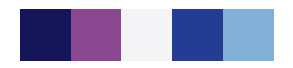

In [350]:
show_palette("AAAABT1QnO3BXGpG4ZFYwIPehnx72KDOrIPuvLQRnH1Afa3iCJIhoeqOH2NR.jpg")